<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/CircuitosDigitais/blob/master/Replace_Missing_Values_Temperature%5BBel%C3%A9m%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/belemdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27757.0,27757.000000,13748.000000,13837.000000,13819.000000,13775.000000,13801.000000,13762.000000,11765.000000,13659.000000,0.0
mean,82191.0,599.978384,8.713442,31.987851,22.829423,6.202004,1.823861,26.586692,84.433574,1.523793,NaN
std,0.0,600.010808,13.749227,1.473330,0.898269,2.857134,0.963746,0.956376,6.106983,0.710772,NaN
min,82191.0,0.000000,0.000000,22.800000,18.500000,0.000000,0.000000,20.000000,61.750000,0.000000,NaN
25%,82191.0,0.000000,0.000000,31.300000,22.200000,4.200000,1.200000,25.960000,80.000000,1.033333,NaN
50%,82191.0,0.000000,3.000000,32.100000,22.900000,6.700000,1.700000,26.620000,84.750000,1.533333,NaN
75%,82191.0,1200.000000,12.000000,32.900000,23.400000,8.600000,2.300000,27.240000,89.000000,2.000000,NaN
max,82191.0,1200.000000,200.800000,37.300000,26.400000,12.100000,16.400000,31.420000,100.000000,5.700000,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82191,1980-01-01,0,NaN,33.0,NaN,6.7,1.5,27.30,NaN,1.900000,NaN
1,82191,1980-01-01,1200,8.0,NaN,22.8,NaN,NaN,NaN,NaN,NaN,NaN
2,82191,1980-01-02,0,NaN,32.7,NaN,7.5,2.6,27.26,NaN,1.633333,NaN
3,82191,1980-01-02,1200,0.0,NaN,21.9,NaN,NaN,NaN,NaN,NaN,NaN
4,82191,1980-01-03,0,NaN,27.8,NaN,3.7,2.6,25.12,NaN,2.100000,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13837.000000,0.0,13775.000000,13801.000000,13762.000000,11765.000000,13659.000000
mean,NaN,31.987851,NaN,6.202004,1.823861,26.586692,84.433574,1.523793
std,NaN,1.473330,NaN,2.857134,0.963746,0.956376,6.106983,0.710772
min,NaN,22.800000,NaN,0.000000,0.000000,20.000000,61.750000,0.000000
25%,NaN,31.300000,NaN,4.200000,1.200000,25.960000,80.000000,1.033333
50%,NaN,32.100000,NaN,6.700000,1.700000,26.620000,84.750000,1.533333
75%,NaN,32.900000,NaN,8.600000,2.300000,27.240000,89.000000,2.000000
max,NaN,37.300000,NaN,12.100000,16.400000,31.420000,100.000000,5.700000


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13748.000000,0.0,13819.000000,0.0,0.0,0.0,0.0,0.0
mean,8.713442,NaN,22.829423,NaN,NaN,NaN,NaN,NaN
std,13.749227,NaN,0.898269,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,18.500000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,22.200000,NaN,NaN,NaN,NaN,NaN
50%,3.000000,NaN,22.900000,NaN,NaN,NaN,NaN,NaN
75%,12.000000,NaN,23.400000,NaN,NaN,NaN,NaN,NaN
max,200.800000,NaN,26.400000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,33.0,6.7,1.5,27.30,NaN,1.900000
1980-01-02,32.7,7.5,2.6,27.26,NaN,1.633333
1980-01-03,27.8,3.7,2.6,25.12,NaN,2.100000
1980-01-04,30.6,1.6,1.5,26.74,NaN,1.366667
1980-01-05,30.8,4.4,1.5,25.82,NaN,0.533333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,8.0,22.8
1980-01-02,0.0,21.9
1980-01-03,0.0,22.8
1980-01-04,16.6,23.5
1980-01-05,4.8,23.2


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,33.0,6.7,1.5,27.30,NaN,1.900000,8.0,22.8
1980-01-02,32.7,7.5,2.6,27.26,NaN,1.633333,0.0,21.9
1980-01-03,27.8,3.7,2.6,25.12,NaN,2.100000,0.0,22.8
1980-01-04,30.6,1.6,1.5,26.74,NaN,1.366667,16.6,23.5
1980-01-05,30.8,4.4,1.5,25.82,NaN,0.533333,4.8,23.2


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13837.000000,13775.000000,13801.000000,13762.000000,11765.000000,13659.000000,13748.000000,13819.000000
mean,31.987851,6.202004,1.823861,26.586692,84.433574,1.523793,8.713442,22.829423
std,1.473330,2.857134,0.963746,0.956376,6.106983,0.710772,13.749227,0.898269
min,22.800000,0.000000,0.000000,20.000000,61.750000,0.000000,0.000000,18.500000
25%,31.300000,4.200000,1.200000,25.960000,80.000000,1.033333,0.000000,22.200000
50%,32.100000,6.700000,1.700000,26.620000,84.750000,1.533333,3.000000,22.900000
75%,32.900000,8.600000,2.300000,27.240000,89.000000,2.000000,12.000000,23.400000
max,37.300000,12.100000,16.400000,31.420000,100.000000,5.700000,200.800000,26.400000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,33.0,6.7,1.5,27.30,NaN,1.900000,8.0,22.8
1980-01-02,32.7,7.5,2.6,27.26,NaN,1.633333,0.0,21.9
1980-01-03,27.8,3.7,2.6,25.12,NaN,2.100000,0.0,22.8
1980-01-04,30.6,1.6,1.5,26.74,NaN,1.366667,16.6,23.5
1980-01-05,30.8,4.4,1.5,25.82,NaN,0.533333,4.8,23.2


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,6.7,1.5,27.30,NaN,1.900000,8.0,22.8
1980-01-02,7.5,2.6,27.26,NaN,1.633333,0.0,21.9
1980-01-03,3.7,2.6,25.12,NaN,2.100000,0.0,22.8
1980-01-04,1.6,1.5,26.74,NaN,1.366667,16.6,23.5
1980-01-05,4.4,1.5,25.82,NaN,0.533333,4.8,23.2


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    33.0
1980-01-02    32.7
1980-01-03    27.8
1980-01-04    30.6
1980-01-05    30.8
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13736.000000,13769.000000,13761.000000,11755.000000,13623.000000,13709.000000,13794.000000
mean,0.024922,-0.777630,0.153512,0.186120,-0.465264,-0.913228,0.096039
std,0.472264,0.117537,0.167473,0.319257,0.249319,0.136953,0.227447
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.305785,-0.853659,0.043783,-0.045752,-0.637427,-1.000000,-0.063291
50%,0.107438,-0.792683,0.159370,0.202614,-0.461988,-0.970120,0.113924
75%,0.421488,-0.719512,0.267951,0.424837,-0.298246,-0.880478,0.240506
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13837, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 750.5869 - mean_absolute_error: 27.2410
Epoch 2/200
 - 1s - loss: 405.4671 - mean_absolute_error: 19.9972
Epoch 3/200
 - 1s - loss: 202.0032 - mean_absolute_error: 14.0492
Epoch 4/200
 - 1s - loss: 84.5649 - mean_absolute_error: 8.9790
Epoch 5/200
 - 1s - loss: 27.2754 - mean_absolute_error: 4.9302
Epoch 6/200
 - 1s - loss: 6.7696 - mean_absolute_error: 2.2889
Epoch 7/200
 - 1s - loss: 2.5196 - mean_absolute_error: 1.2624
Epoch 8/200
 - 1s - loss: 2.1612 - mean_absolute_error: 1.1057
Epoch 9/200
 - 1s - loss: 2.1530 - mean_absolute_error: 1.0939
Epoch 10/200
 - 1s - loss: 2.1531 - mean_absolute_error: 1.0952
Epoch 11/200
 - 1s - loss: 

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.494415, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.494415 (0.006297) {'batch_size': 10, 'camadas': 2, 'units': 7}


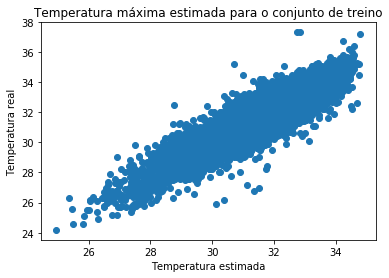

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.        0.8817963]
 [0.8817963 1.       ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

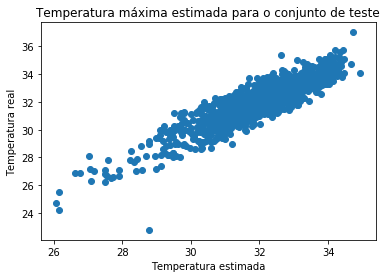

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.89492966]
 [0.89492966 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.5271978367270762


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.4660350263466193


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,33.0,6.7,1.5,27.30,NaN,1.900000,8.0
1980-01-02,32.7,7.5,2.6,27.26,NaN,1.633333,0.0
1980-01-03,27.8,3.7,2.6,25.12,NaN,2.100000,0.0
1980-01-04,30.6,1.6,1.5,26.74,NaN,1.366667,16.6
1980-01-05,30.8,4.4,1.5,25.82,NaN,0.533333,4.8


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    22.8
1980-01-02    21.9
1980-01-03    22.8
1980-01-04    23.5
1980-01-05    23.2
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13794.000000,13715.000000,13750.000000,13730.000000,11726.000000,13600.000000,13689.000000
mean,0.267206,0.024540,-0.777924,-0.143277,0.186193,-0.465232,-0.913105
std,0.203302,0.472113,0.117240,0.221288,0.319439,0.249352,0.137056
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.172414,-0.305785,-0.853659,-0.289100,-0.045752,-0.637427,-1.000000
50%,0.282759,0.107438,-0.792683,-0.137441,0.202614,-0.461988,-0.970120
75%,0.393103,0.421488,-0.719512,0.009479,0.424837,-0.298246,-0.880478
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13819, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 338.2324 - mean_absolute_error: 18.2044
Epoch 2/200
 - 1s - loss: 133.7134 - mean_absolute_error: 11.4083
Epoch 3/200
 - 1s - loss: 42.9142 - mean_absolute_error: 6.3663
Epoch 4/200
 - 1s - loss: 9.3405 - mean_absolute_error: 2.8166
Epoch 5/200
 - 1s - loss: 1.6210 - mean_absolute_error: 1.0452
Epoch 6/200
 - 1s - loss: 0.8316 - mean_absolute_error: 0.7255
Epoch 7/200
 - 1s - loss: 0.8083 - mean_absolute_error: 0.7101
Epoch 8/200
 - 1s - loss: 0.8083 - mean_absolute_error: 0.7101
Epoch 9/200
 - 1s - loss: 0.8083 - mean_absolute_error: 0.7102
Epoch 10/200
 - 1s - loss: 0.8087 - mean_absolute_error: 0.7103
Epoch 11/200
 - 1s - loss: 0.8089 - mean_absolute_error: 0.7103
Epoch 12/200
 - 1s - loss: 0.8089 - mean_absolute_error: 0.7102
Epoch 13/200
 - 1s - lo

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.382786, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.382786 (0.009933) {'batch_size': 10, 'camadas': 2, 'units': 7}


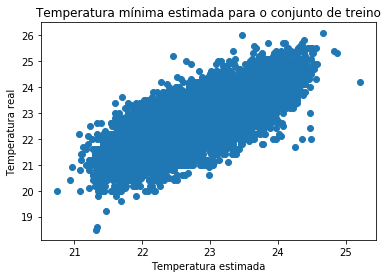

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.74120412]
 [0.74120412 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

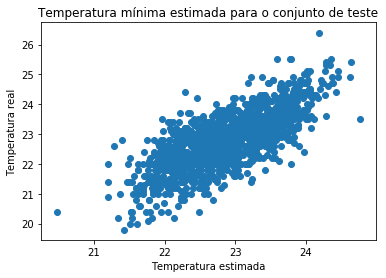

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.74537141]
 [0.74537141 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.4884111045583458


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.3836136962819594


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaBelém.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaBelém.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))